In [1]:
# Data manipulation / splitting
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Machine learning models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model evaluation metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_recall_curve,
    auc
)

# Visualization / plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [2]:
crashes = pd.read_csv("crashesClean.csv")

# Drop 2 rows w/ missing ward data 
crashes = crashes.dropna(subset=['WARD'])

crashes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303604 entries, 0 to 303605
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ADDRESS               303604 non-null  object 
 1   LATITUDE              303604 non-null  float64
 2   LONGITUDE             303604 non-null  float64
 3   WARD                  303604 non-null  object 
 4   TOTAL_VEHICLES        303604 non-null  int64  
 5   TOTAL_BICYCLES        303604 non-null  int64  
 6   TOTAL_PEDESTRIANS     303604 non-null  int64  
 7   NEARESTINTSTREETNAME  303604 non-null  object 
 8   OFFINTERSECTION       303604 non-null  float64
 9   crash_datetime        303604 non-null  object 
 10  year                  303604 non-null  int64  
 11  month                 303604 non-null  int64  
 12  weekday               303604 non-null  object 
 13  fatalities            303604 non-null  float64
 14  majorinjuries         303604 non-null  float64
 15  minor

In [3]:
# Convert severity column to binary 0 - Property Damage Only, 1 - Injury/Fatal
crashes['severe'] = crashes['severity'].map({
    'Property Damage Only': 0,
    'Injury': 1,
    'Fatal': 1
})

print(crashes['severity'].value_counts())

severity
Property Damage Only    219833
Injury                   83204
Fatal                      567
Name: count, dtype: int64


In [4]:
# Drop columns that might leak data (fatalities, majorinjuries, minorinjuries)
columns_to_drop = ['fatalities', 'majorinjuries', 'minorinjuries', 'severity']

# Drop non-numeric columns: ADDRESS, 

crashes = crashes.drop(columns=columns_to_drop)

print(crashes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 303604 entries, 0 to 303605
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ADDRESS               303604 non-null  object 
 1   LATITUDE              303604 non-null  float64
 2   LONGITUDE             303604 non-null  float64
 3   WARD                  303604 non-null  object 
 4   TOTAL_VEHICLES        303604 non-null  int64  
 5   TOTAL_BICYCLES        303604 non-null  int64  
 6   TOTAL_PEDESTRIANS     303604 non-null  int64  
 7   NEARESTINTSTREETNAME  303604 non-null  object 
 8   OFFINTERSECTION       303604 non-null  float64
 9   crash_datetime        303604 non-null  object 
 10  year                  303604 non-null  int64  
 11  month                 303604 non-null  int64  
 12  weekday               303604 non-null  object 
 13  speeding              303604 non-null  int64  
 14  impaired              303604 non-null  int64  
 15  sever

In [5]:
# Split Data
X = crashes.drop('severe', axis=1)
y = crashes['severe']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=47
)

In [6]:
# Keep only numeric columns
X_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test[X_numeric.columns]

# Random Forest with class weights
rf_model = RandomForestClassifier(class_weight={0:1, 1:5}, n_estimators=500, random_state=47)
rf_model.fit(X_numeric, y_train)

# Gradient Boosting using sample weights
weights = np.where(y_train==1, 5, 1)  # weight severe crashes higher
gb_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, max_depth=3, random_state=47)
gb_model.fit(X_numeric, y_train, sample_weight=weights)

print("Models trained successfully!")

Models trained successfully!


In [7]:
# Dictionary to store metrics
metrics = {'Random Forest': {}, 'Gradient Boosting': {}}

# Helper function to compute PRAUC
def compute_prauc(model, X, y):
    # Get predicted probabilities for positive class
    y_probs = model.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_probs)
    return auc(recall, precision)

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test_numeric)
metrics['Random Forest']['Accuracy'] = accuracy_score(y_test, y_pred_rf)
metrics['Random Forest']['F1'] = f1_score(y_test, y_pred_rf)
metrics['Random Forest']['PRAUC'] = compute_prauc(rf_model, X_test_numeric, y_test)

# Evaluate Gradient Boosting
y_pred_gb = gb_model.predict(X_test_numeric)
metrics['Gradient Boosting']['Accuracy'] = accuracy_score(y_test, y_pred_gb)
metrics['Gradient Boosting']['F1'] = f1_score(y_test, y_pred_gb)
metrics['Gradient Boosting']['PRAUC'] = compute_prauc(gb_model, X_test_numeric, y_test)

# Print confusion matrices
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nGradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))


Random Forest Confusion Matrix:
[[40567  3379]
 [12011  4764]]

Gradient Boosting Confusion Matrix:
[[ 9912 34034]
 [ 1473 15302]]


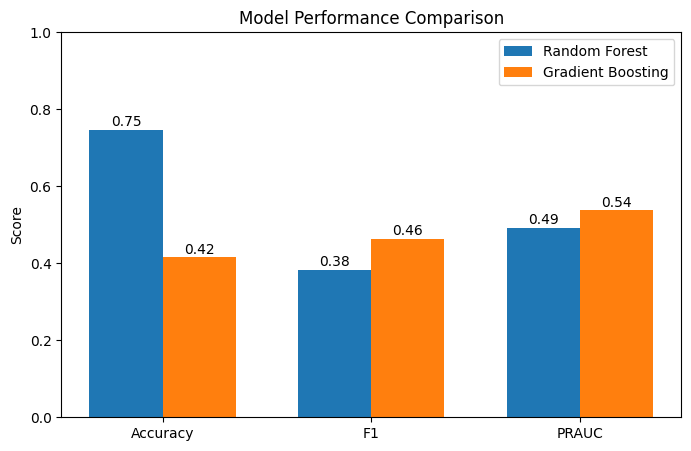

In [8]:
# Create bar graph 
models = list(metrics.keys())
scores = ['Accuracy', 'F1', 'PRAUC']

# Prepare data
bar_width = 0.35
x = np.arange(len(scores))
rf_values = [metrics['Random Forest'][s] for s in scores]
gb_values = [metrics['Gradient Boosting'][s] for s in scores]

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - bar_width/2, rf_values, bar_width, label='Random Forest')
ax.bar(x + bar_width/2, gb_values, bar_width, label='Gradient Boosting')

ax.set_xticks(x)
ax.set_xticklabels(scores)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()

for i, (rf_val, gb_val) in enumerate(zip(rf_values, gb_values)):
    ax.text(i - bar_width/2, rf_val + 0.01, f"{rf_val:.2f}", ha='center')
    ax.text(i + bar_width/2, gb_val + 0.01, f"{gb_val:.2f}", ha='center')

plt.show()

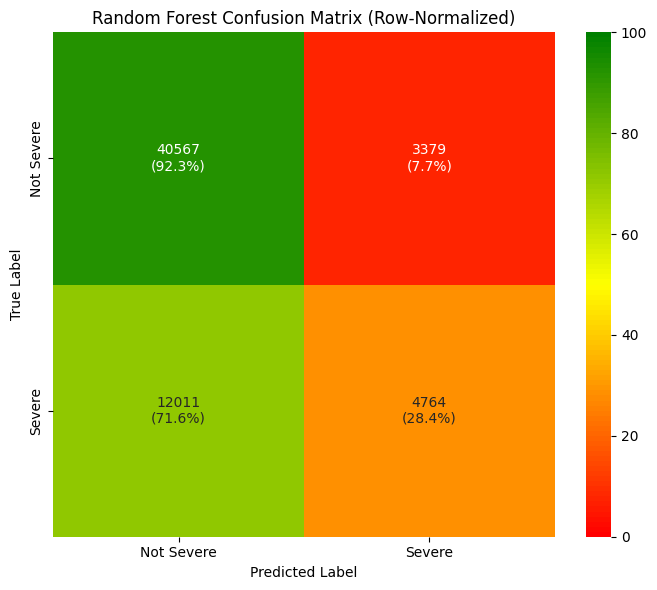

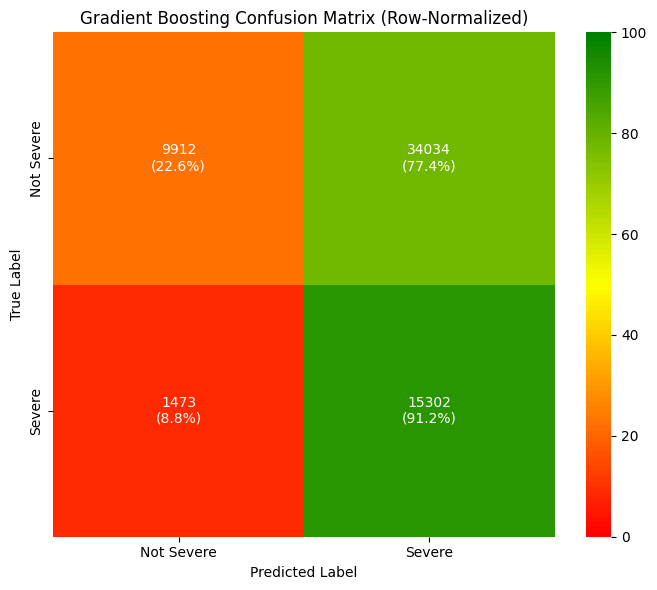

In [9]:
# Class labels
labels = ["Not Severe", "Severe"]

# Helper function to plot heatmapped confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    # 1. Compute raw confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # 2. Row-wise normalization (percent within true class)
    cm_row_percent = cm / cm.sum(axis=1, keepdims=True) * 100

    # 3. Create annotation text: count + percent
    annot_text = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot_text[i, j] = f"{cm[i, j]}\n({cm_row_percent[i, j]:.1f}%)"

    # 4. Red → Green colormap
    red_green = LinearSegmentedColormap.from_list(
        "red_green", ["red", "yellow", "green"], N=100
    )

    # 5. Plot heatmap
    plt.figure(figsize=(7,6))
    sns.heatmap(
        cm_row_percent,
        annot=annot_text,
        fmt="",
        cmap=red_green,
        vmin=0,
        vmax=100,
        cbar=True,
        xticklabels=labels,
        yticklabels=labels
    )

    plt.title(title + " (Row-Normalized)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Plot for Random Forest 
y_pred_rf = rf_model.predict(X_test_numeric)  # make sure X_test contains numeric features only
plot_confusion_matrix(y_test, y_pred_rf, title="Random Forest Confusion Matrix")

# Plot for Gradient Boosting 
y_pred_gb = gb_model.predict(X_test_numeric)
plot_confusion_matrix(y_test, y_pred_gb, title="Gradient Boosting Confusion Matrix")


Weighted Ensemble Metrics:
Accuracy: 0.646
F1 Score: 0.499
PRAUC: 0.535
Ensemble Confusion Matrix
[[28496 15450]
 [ 6054 10721]]


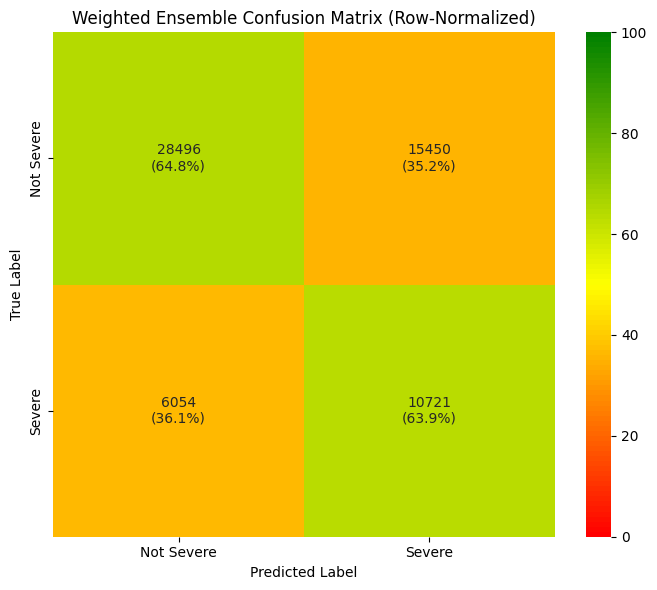

In [10]:
# Ensemble Model 
# Get predicted probabilities from RF & GB
rf_probs = rf_model.predict_proba(X_test_numeric)[:, 1]  # probability of class 1
gb_probs = gb_model.predict_proba(X_test_numeric)[:, 1]

# Weighted probability ensemble 
weight_rf = 0.3  # less weight for class 1 from RF
weight_gb = 0.7  # more weight for class 1 from GB

ensemble_probs = weight_rf * rf_probs + weight_gb * gb_probs

# Apply threshold to get final predictions
threshold = 0.5
y_pred_ensemble = (ensemble_probs >= threshold).astype(int)

# Compute metrics 
accuracy = accuracy_score(y_test, y_pred_ensemble)
f1 = f1_score(y_test, y_pred_ensemble)

# Compute PRAUC using probabilities
precision, recall, _ = precision_recall_curve(y_test, ensemble_probs)
prauc = auc(recall, precision)

print(f"Weighted Ensemble Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"PRAUC: {prauc:.3f}")

print("Ensemble Confusion Matrix")
print(confusion_matrix(y_test, y_pred_ensemble))

# Confusion matrix & heatmap 
labels = ["Not Severe", "Severe"]
cm = confusion_matrix(y_test, y_pred_ensemble)
cm_row_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Annotate cells with count + percent
annot_text = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot_text[i, j] = f"{cm[i, j]}\n({cm_row_percent[i, j]:.1f}%)"

# Red → Green colormap
red_green = LinearSegmentedColormap.from_list("red_green", ["red", "yellow", "green"], N=100)

# Plot heatmap
plt.figure(figsize=(7,6))
sns.heatmap(
    cm_row_percent,
    annot=annot_text,
    fmt="",
    cmap=red_green,
    vmin=0,
    vmax=100,
    cbar=True,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Weighted Ensemble Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


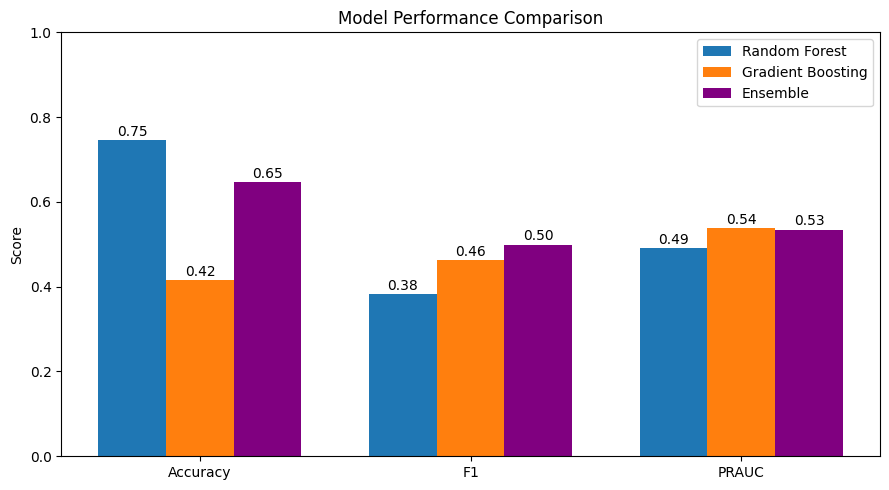

In [11]:
# Compute ensemble predicted probabilities & predictions 
# Weighted combination of probabilities
weight_rf = 0.3
weight_gb = 0.7
ensemble_probs = weight_rf * rf_model.predict_proba(X_test_numeric)[:,1] + weight_gb * gb_model.predict_proba(X_test_numeric)[:,1]

# Convert to final predictions using threshold
threshold = 0.5
y_pred_ensemble = (ensemble_probs >= threshold).astype(int)

# Store metrics for all models 
metrics = {}

# Random Forest
rf_probs = rf_model.predict_proba(X_test_numeric)[:,1]
y_pred_rf = rf_model.predict(X_test_numeric)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_probs)
metrics['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'F1': f1_score(y_test, y_pred_rf),
    'PRAUC': auc(recall_rf, precision_rf)
}

# Gradient Boosting
gb_probs = gb_model.predict_proba(X_test_numeric)[:,1]
y_pred_gb = gb_model.predict(X_test_numeric)
precision_gb, recall_gb, _ = precision_recall_curve(y_test, gb_probs)
metrics['Gradient Boosting'] = {
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'F1': f1_score(y_test, y_pred_gb),
    'PRAUC': auc(recall_gb, precision_gb)
}

# Ensemble
precision_ens, recall_ens, _ = precision_recall_curve(y_test, ensemble_probs)
metrics['Ensemble'] = {
    'Accuracy': accuracy_score(y_test, y_pred_ensemble),
    'F1': f1_score(y_test, y_pred_ensemble),
    'PRAUC': auc(recall_ens, precision_ens)
}

# Create bar graph 
models_list = list(metrics.keys())  # ['Random Forest', 'Gradient Boosting', 'Ensemble']
scores = ['Accuracy', 'F1', 'PRAUC']

# Prepare data
bar_width = 0.25
x = np.arange(len(scores))

rf_values = [metrics['Random Forest'][s] for s in scores]
gb_values = [metrics['Gradient Boosting'][s] for s in scores]
ensemble_values = [metrics['Ensemble'][s] for s in scores]

# Plot
fig, ax = plt.subplots(figsize=(9,5))
ax.bar(x - bar_width, rf_values, bar_width, label='Random Forest')
ax.bar(x, gb_values, bar_width, label='Gradient Boosting')
ax.bar(x + bar_width, ensemble_values, bar_width, label='Ensemble', color='purple')  # optional highlight

ax.set_xticks(x)
ax.set_xticklabels(scores)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()

# Add value annotations
for i in range(len(scores)):
    ax.text(i - bar_width, rf_values[i] + 0.01, f"{rf_values[i]:.2f}", ha='center')
    ax.text(i, gb_values[i] + 0.01, f"{gb_values[i]:.2f}", ha='center')
    ax.text(i + bar_width, ensemble_values[i] + 0.01, f"{ensemble_values[i]:.2f}", ha='center')

plt.tight_layout()
plt.show()


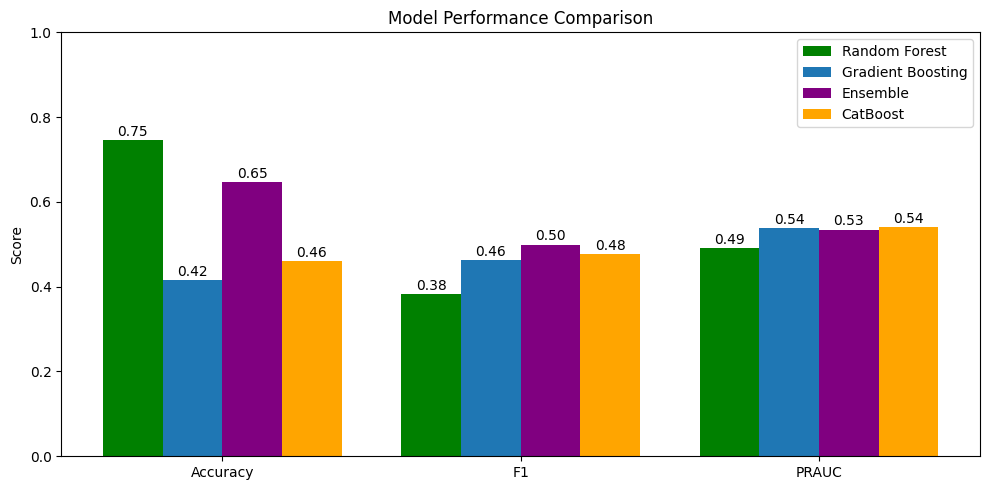

In [12]:
# Add CatBoost metrics 
# Values from 'Crashes - CatBoost Tuned' file
metrics['CatBoost'] = {
    'Accuracy': 0.461,
    'F1': 0.476,
    'PRAUC': 0.541
}

# Create bar graph with 4 models 
models_list = list(metrics.keys())  # ['Random Forest', 'Gradient Boosting', 'Ensemble', 'CatBoost']
scores = ['Accuracy', 'F1', 'PRAUC']

# Prepare data
bar_width = 0.2  # narrower to fit 4 bars per group
x = np.arange(len(scores))

rf_values = [metrics['Random Forest'][s] for s in scores]
gb_values = [metrics['Gradient Boosting'][s] for s in scores]
ensemble_values = [metrics['Ensemble'][s] for s in scores]
cb_values = [metrics['CatBoost'][s] for s in scores]

# Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x - 1.5*bar_width, rf_values, bar_width, label='Random Forest', color = 'green')
ax.bar(x - 0.5*bar_width, gb_values, bar_width, label='Gradient Boosting')
ax.bar(x + 0.5*bar_width, ensemble_values, bar_width, label='Ensemble', color='purple')  # optional highlight
ax.bar(x + 1.5*bar_width, cb_values, bar_width, label='CatBoost', color='orange')  # optional highlight

ax.set_xticks(x)
ax.set_xticklabels(scores)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()

# Add value annotations
for i in range(len(scores)):
    ax.text(i - 1.5*bar_width, rf_values[i] + 0.01, f"{rf_values[i]:.2f}", ha='center')
    ax.text(i - 0.5*bar_width, gb_values[i] + 0.01, f"{gb_values[i]:.2f}", ha='center')
    ax.text(i + 0.5*bar_width, ensemble_values[i] + 0.01, f"{ensemble_values[i]:.2f}", ha='center')
    ax.text(i + 1.5*bar_width, cb_values[i] + 0.01, f"{cb_values[i]:.2f}", ha='center')

plt.tight_layout()
plt.show()


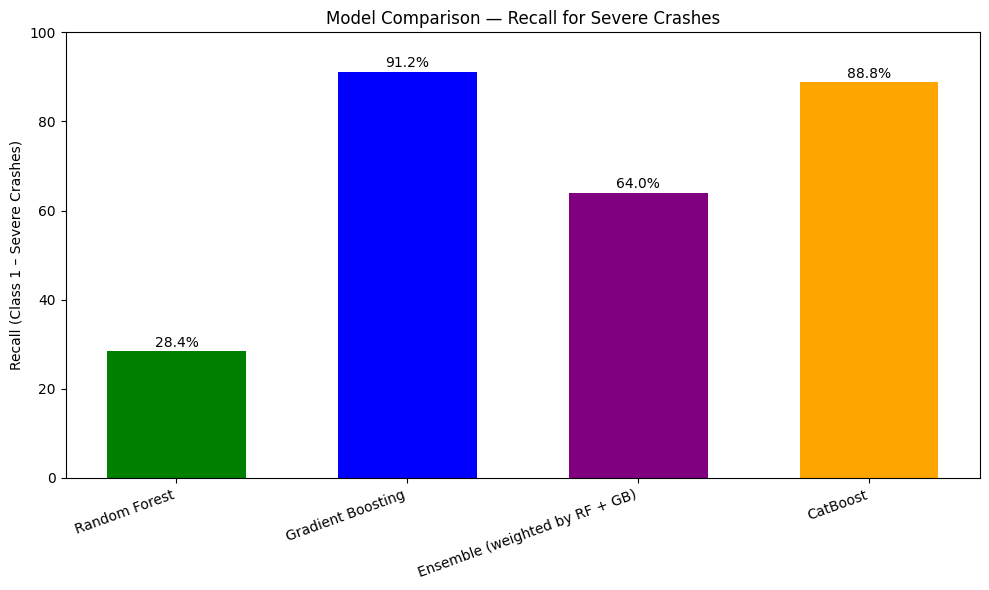

In [13]:
# Compare recal of all 4 models: 
recall = {
    'Random Forest' : 28.4, 
    'Gradient Boosting' : 91.2, 
    'Ensemble (weighted by RF + GB)' : 64, 
    'CatBoost' : 88.8 }

# Colors for each model
colors = {
    'Random Forest': 'green',
    'Gradient Boosting': 'blue',
    'Ensemble (weighted by RF + GB)': 'purple',
    'CatBoost': 'orange'
}

# Prepare Data
models = list(recall.keys())
values = [recall[m] for m in models]
bar_colors = [colors[m] for m in models]

x = np.arange(len(models))
bar_width = 0.6

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(x, values, bar_width, color=bar_colors)

# Add value labels above bars
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

plt.xticks(x, models, rotation=20, ha='right')
plt.ylim(0, 100)
plt.ylabel("Recall (Class 1 – Severe Crashes)")
plt.title("Model Comparison — Recall for Severe Crashes")

plt.tight_layout()
plt.show()
